# Bike Sharing Dataset
- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

In [2]:
bikes = pd.read_csv("day.csv")

In [3]:
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Identifying any data types which need to be converted

In [4]:
bikes.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### No Missing values in the dataset

In [5]:
 bikes.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
bikes.shape

(730, 16)

### `dteday` needs to be converted to date object

In [7]:
bikes.dteday = pd.to_datetime(bikes.dteday, format='%d-%m-%Y')

### Converting mnth to Categorical Variable 

In [8]:
bikes['mnth']=bikes['dteday'].dt.strftime('%B')

In [9]:
bikes.mnth.value_counts()

May          62
January      62
December     62
July         62
August       62
March        62
October      62
September    60
November     60
June         60
April        60
February     56
Name: mnth, dtype: int64

### Converting `weekday` to categorical variable 

In [10]:
bikes.groupby(['weekday']).workingday.sum()

weekday
0      0
1     90
2    103
3    102
4    102
5    102
6      0
Name: workingday, dtype: int64

### From above it is clear that all working days are from 1-5 represting Mon - Fri

In [11]:
day_name = {0 : 'Sunday', 1 : 'Monday', 2 : 'Tuesday', 3 : 'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'} 
bikes = bikes.replace({'weekday':day_name})
bikes.weekday.value_counts()

Saturday     105
Sunday       105
Monday       105
Thursday     104
Tuesday      104
Friday       104
Wednesday    103
Name: weekday, dtype: int64

### Converting categorical column for season
    - 1: spring
    - 2: summer
    - 3: fall
    - 4: winter

In [12]:
season_name = {1 : 'Spring', 2 : 'Summer', 3 : 'Fall',4:'Winter'} 
bikes = bikes.replace({'season':season_name})
bikes.season.value_counts()

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64

### Converting categorical column for Weather situation
+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [13]:
weathersit_name = {1 : 'Clear, Few clouds, Partly cloudy, Partly cloudy', 2 : 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 3 : 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'} 
bikes = bikes.replace({'weathersit':weathersit_name})
bikes.weathersit.value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            463
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               246
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     21
Name: weathersit, dtype: int64

### Dropping Columns which are uneccessary and redundant
- Dropping dteday as we have already captured year, month and weekday
- dropping casual and registered as we only need to find the demand for the service 

In [14]:
bikes = bikes.drop(columns=['instant','dteday','casual','registered'])

----

# Exploratory Data Analysis to identify driving factors 

----

### Correlation of the dataframe

<AxesSubplot:>

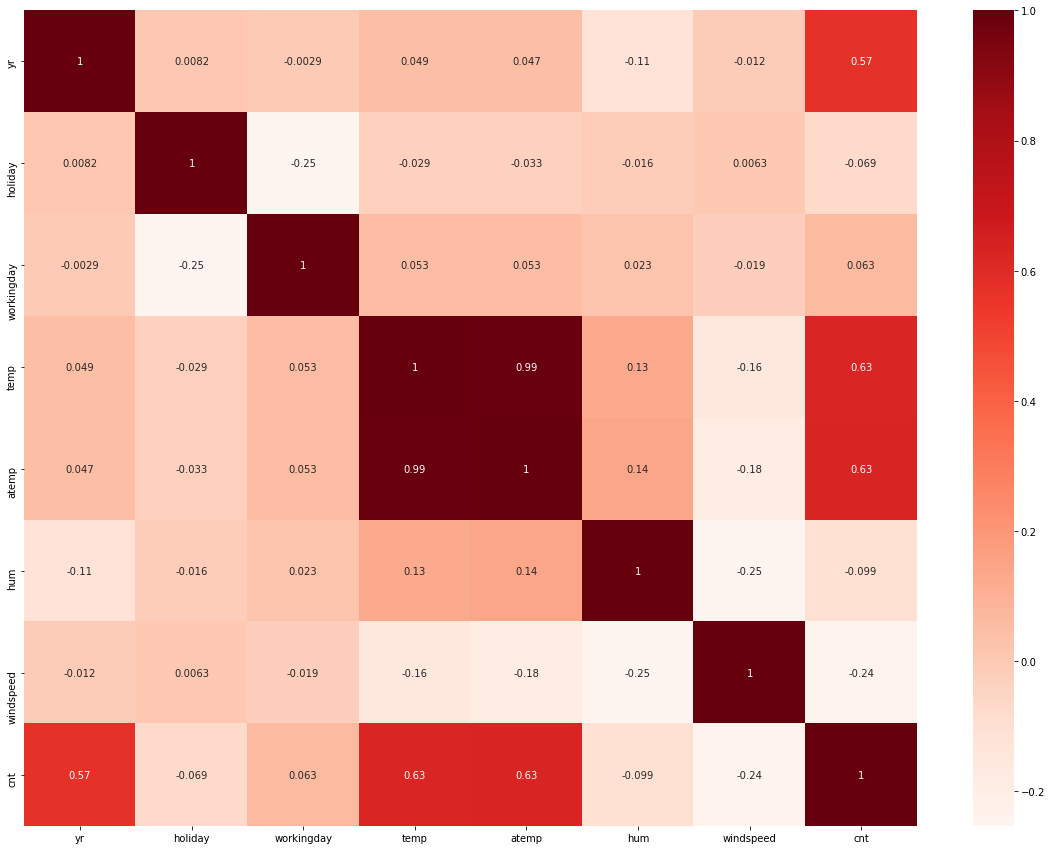

In [15]:
plt.figure(figsize=(20,15))
sb.heatmap(bikes.corr(),annot=True,cmap='Reds')

### Observations:
- cnt has high correlation with temp and yr
- As temperature can play huge role in determine if the consumer is willing to ride the bike or not
- yr suggest demand for bike sharing in year's 2018 and 2019
- atemp and temp are highly correlated dropping one of them to avoid __multicollinearlity__

### Dropping `atemp` as it has high correlation with `temp`

In [16]:
bikes = bikes.drop(columns=['atemp'])

## Visualising patterns across all the attributes

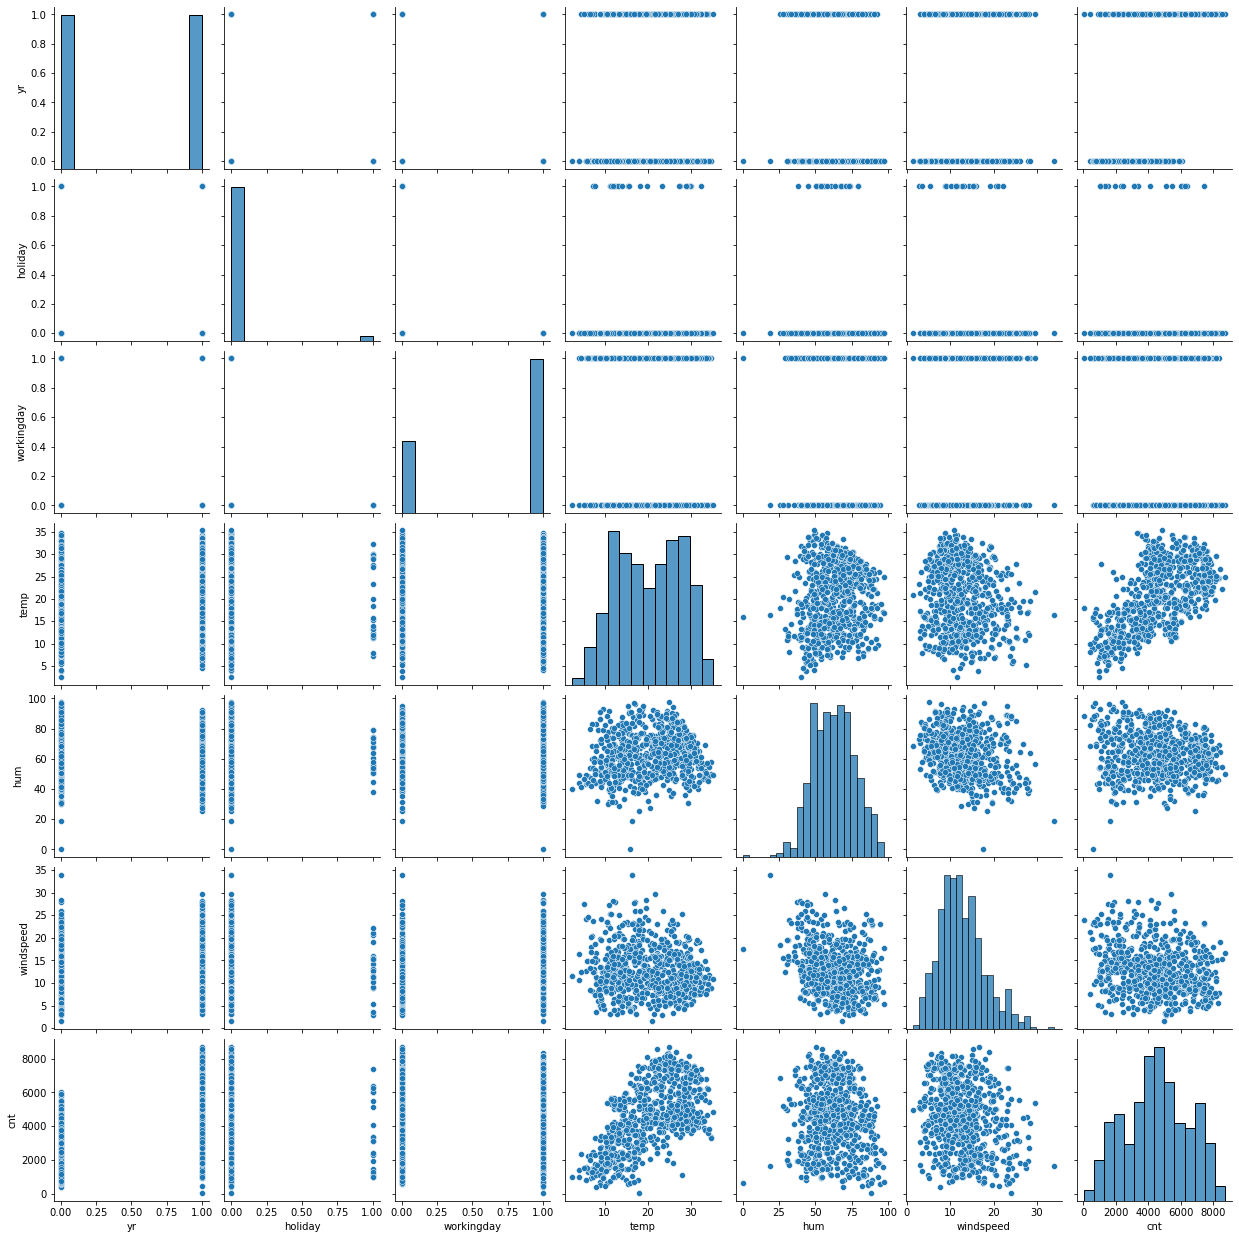

In [17]:
sb.pairplot(bikes)

### Observation
- temp definitely has high correlation with the demand as the scatterplot between cnt and temp follows an upward trend

### Analysis on demand based on weekday

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

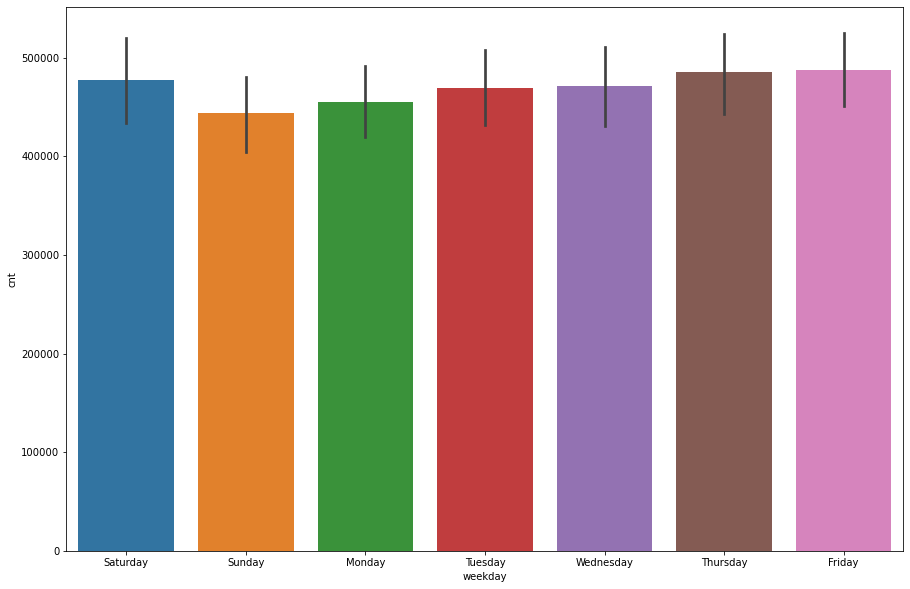

In [18]:
plt.figure(figsize=(15,10))
sb.barplot(x='weekday',y='cnt',data=bikes,estimator = sum)

### Observation: 
- No significant effect on bike demand based on the day
- Let's see if this has any significance after building the model

### Analysis on demand based on Season

<AxesSubplot:xlabel='season', ylabel='cnt'>

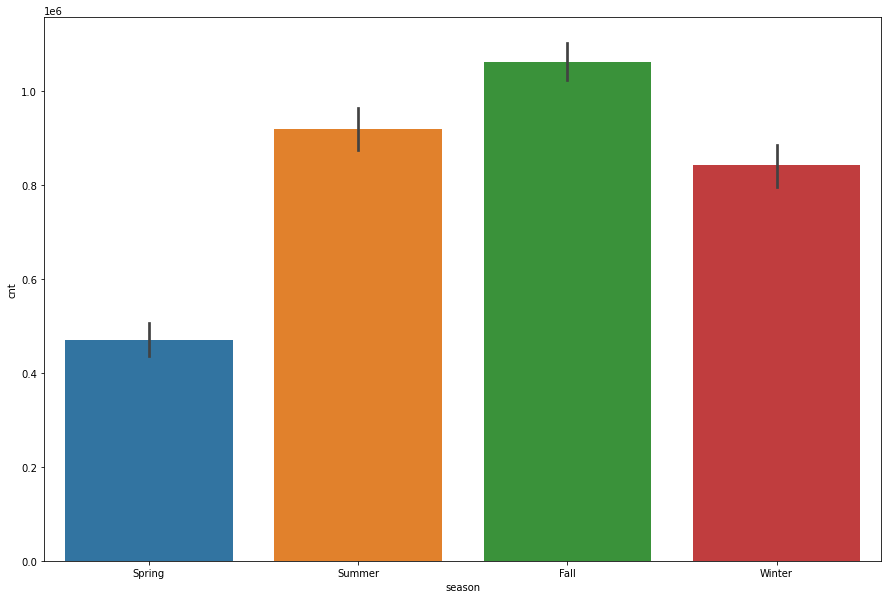

In [19]:
plt.figure(figsize=(15,10))
sb.barplot(x='season',y='cnt',data=bikes,estimator = sum)

### Observation: 
- Bike demand is low during spring

### Analysis on demand based on holiday

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

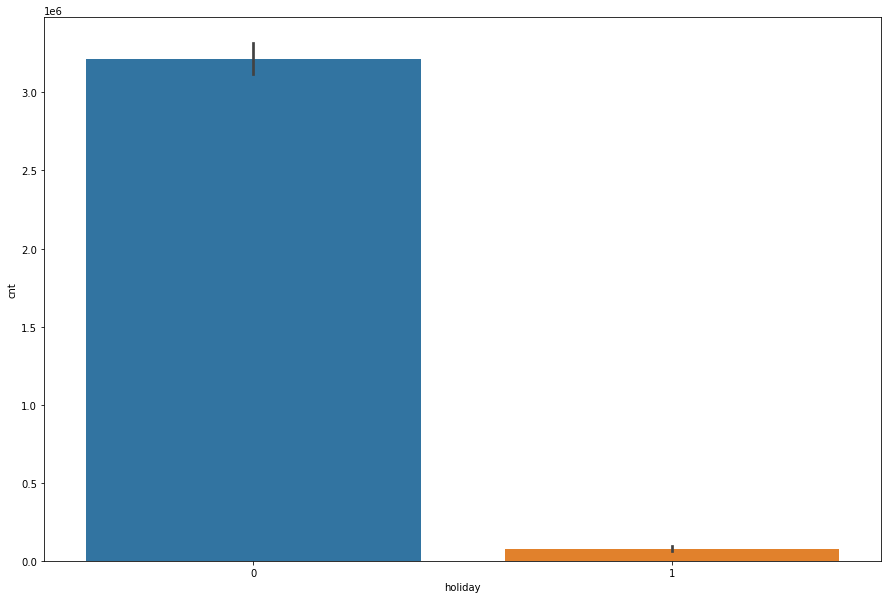

In [20]:
plt.figure(figsize=(15,10))
sb.barplot(x='holiday',y='cnt',data=bikes,estimator = sum)

### Observation: 
- Bike demand for leasure and travellers seems to very low as most traffic is from employees who drive it to work

### Analysis on demand based on weathersit

(array([0, 1, 2]),
 [Text(0, 0, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist'),
  Text(1, 0, 'Clear, Few clouds, Partly cloudy, Partly cloudy'),
  Text(2, 0, 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds')])

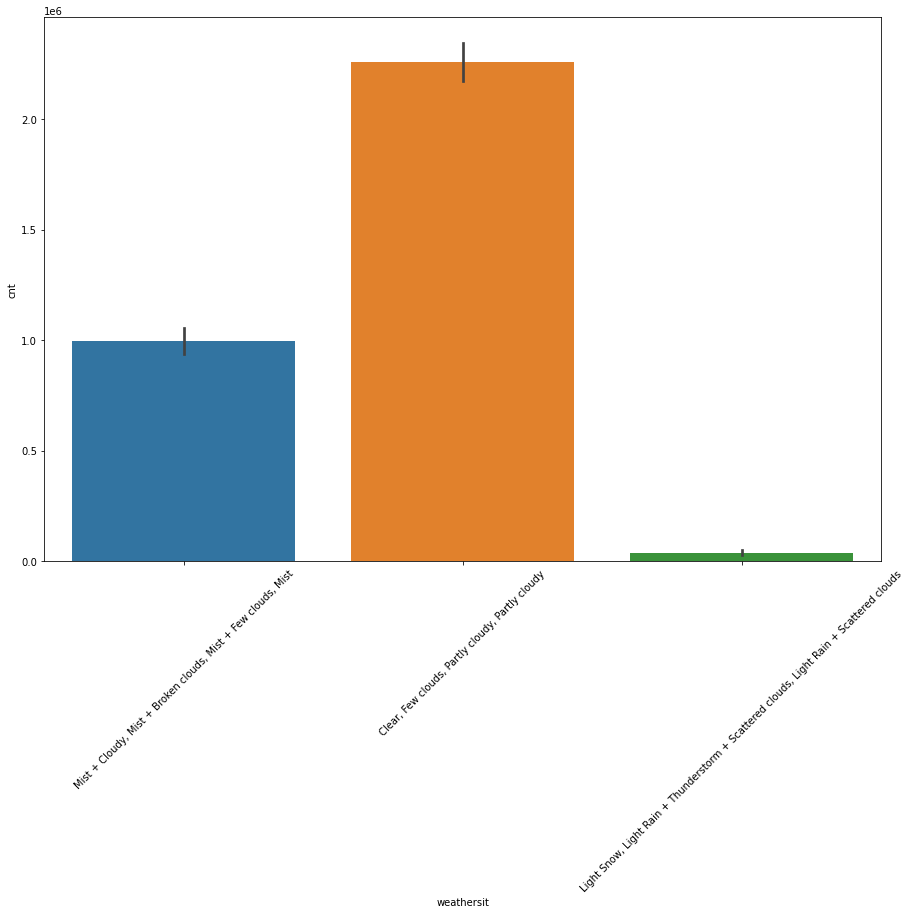

In [21]:
plt.figure(figsize=(15,10))
sb.barplot(x='weathersit',y='cnt',data=bikes,estimator = sum)
plt.xticks(rotation=45)

### Observation: 
- Bike demand is definitely more when there clear, few clouds as it is more convinient

### Visualising months and seasons

<AxesSubplot:xlabel='season', ylabel='cnt'>

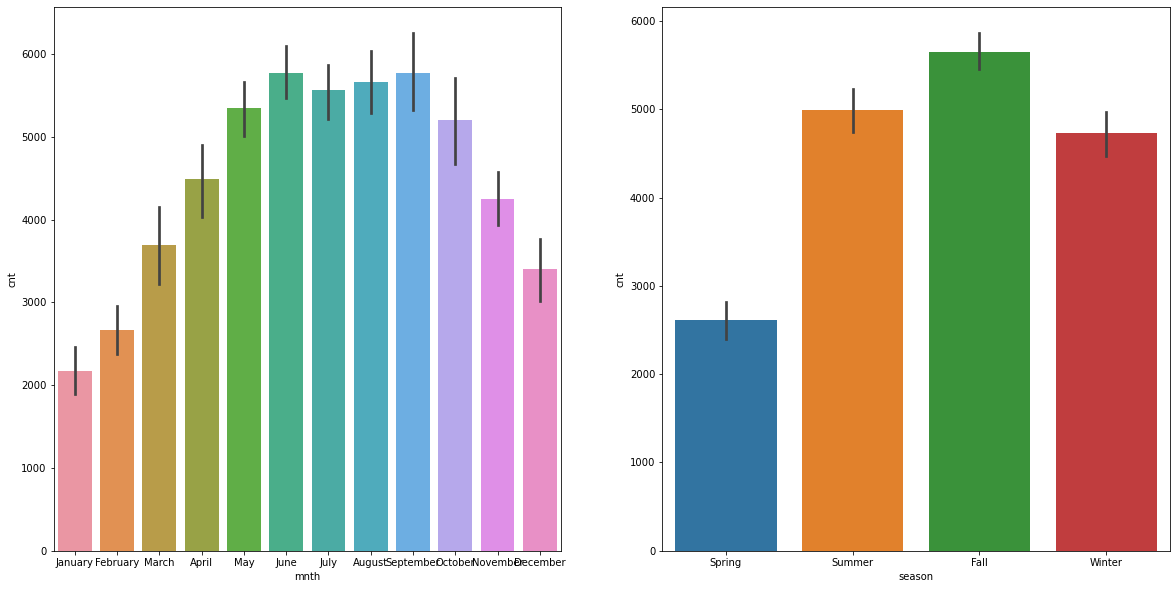

In [22]:
f,axes = plt.subplots(1,2,figsize=(20,10))

sb.barplot(bikes.mnth,bikes.cnt,ax = axes[0])
sb.barplot(bikes.season,bikes.cnt, ax = axes[1])

### Obeservation:

- As its visually clear that months and seasons follow a similar trend as they are correlated
- Months attribute can be dropped as season is solving our purpose

### Dropping mnths feature

In [23]:
bikes = bikes.drop(columns = ['mnth'])


---

# Linear Regression Model

---

## Creating Dummy variables for categorical attributes
- season
- weathersit

In [24]:
bikes.columns

Index(['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [25]:
modified_bikes = pd.concat([bikes,pd.get_dummies(bikes.season,drop_first = True),pd.get_dummies(bikes.weathersit,drop_first = True),pd.get_dummies(bikes.weekday,drop_first = True)],axis=1)

In [26]:
modified_bikes.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,...,Summer,Winter,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Spring,0,0,Saturday,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.110847,80.5833,10.749882,985,...,0,0,0,1,0,1,0,0,0,0
1,Spring,0,0,Sunday,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",14.902598,69.6087,16.652113,801,...,0,0,0,1,0,0,1,0,0,0
2,Spring,0,0,Monday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.050924,43.7273,16.636703,1349,...,0,0,0,0,1,0,0,0,0,0
3,Spring,0,0,Tuesday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",8.200000,59.0435,10.739832,1562,...,0,0,0,0,0,0,0,0,1,0
4,Spring,0,0,Wednesday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.305237,43.6957,12.522300,1600,...,0,0,0,0,0,0,0,0,0,1


### Dropping categorical columns as we have dummies for them

In [27]:
modified_bikes = modified_bikes.drop(columns = ['weathersit','season','weekday'])

### Dropping one column from each dummy variable as we only need `n-1`

In [28]:
modified_bikes.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'Spring', 'Summer', 'Winter',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

### Splitting data into Train and Test set

In [29]:
np.random.seed(100)
df_train,df_test = train_test_split(modified_bikes,train_size = 0.7, random_state=100)

### Scaling numerical features using MinMaxScaling

In [30]:
scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed','cnt']

In [31]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [32]:
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,"Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,0.029412,0.345098,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824
std,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,0.169124,0.475867,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
df_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'Spring', 'Summer', 'Winter',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

### Let's check the correlation coefficients to see which variables are highly correlated


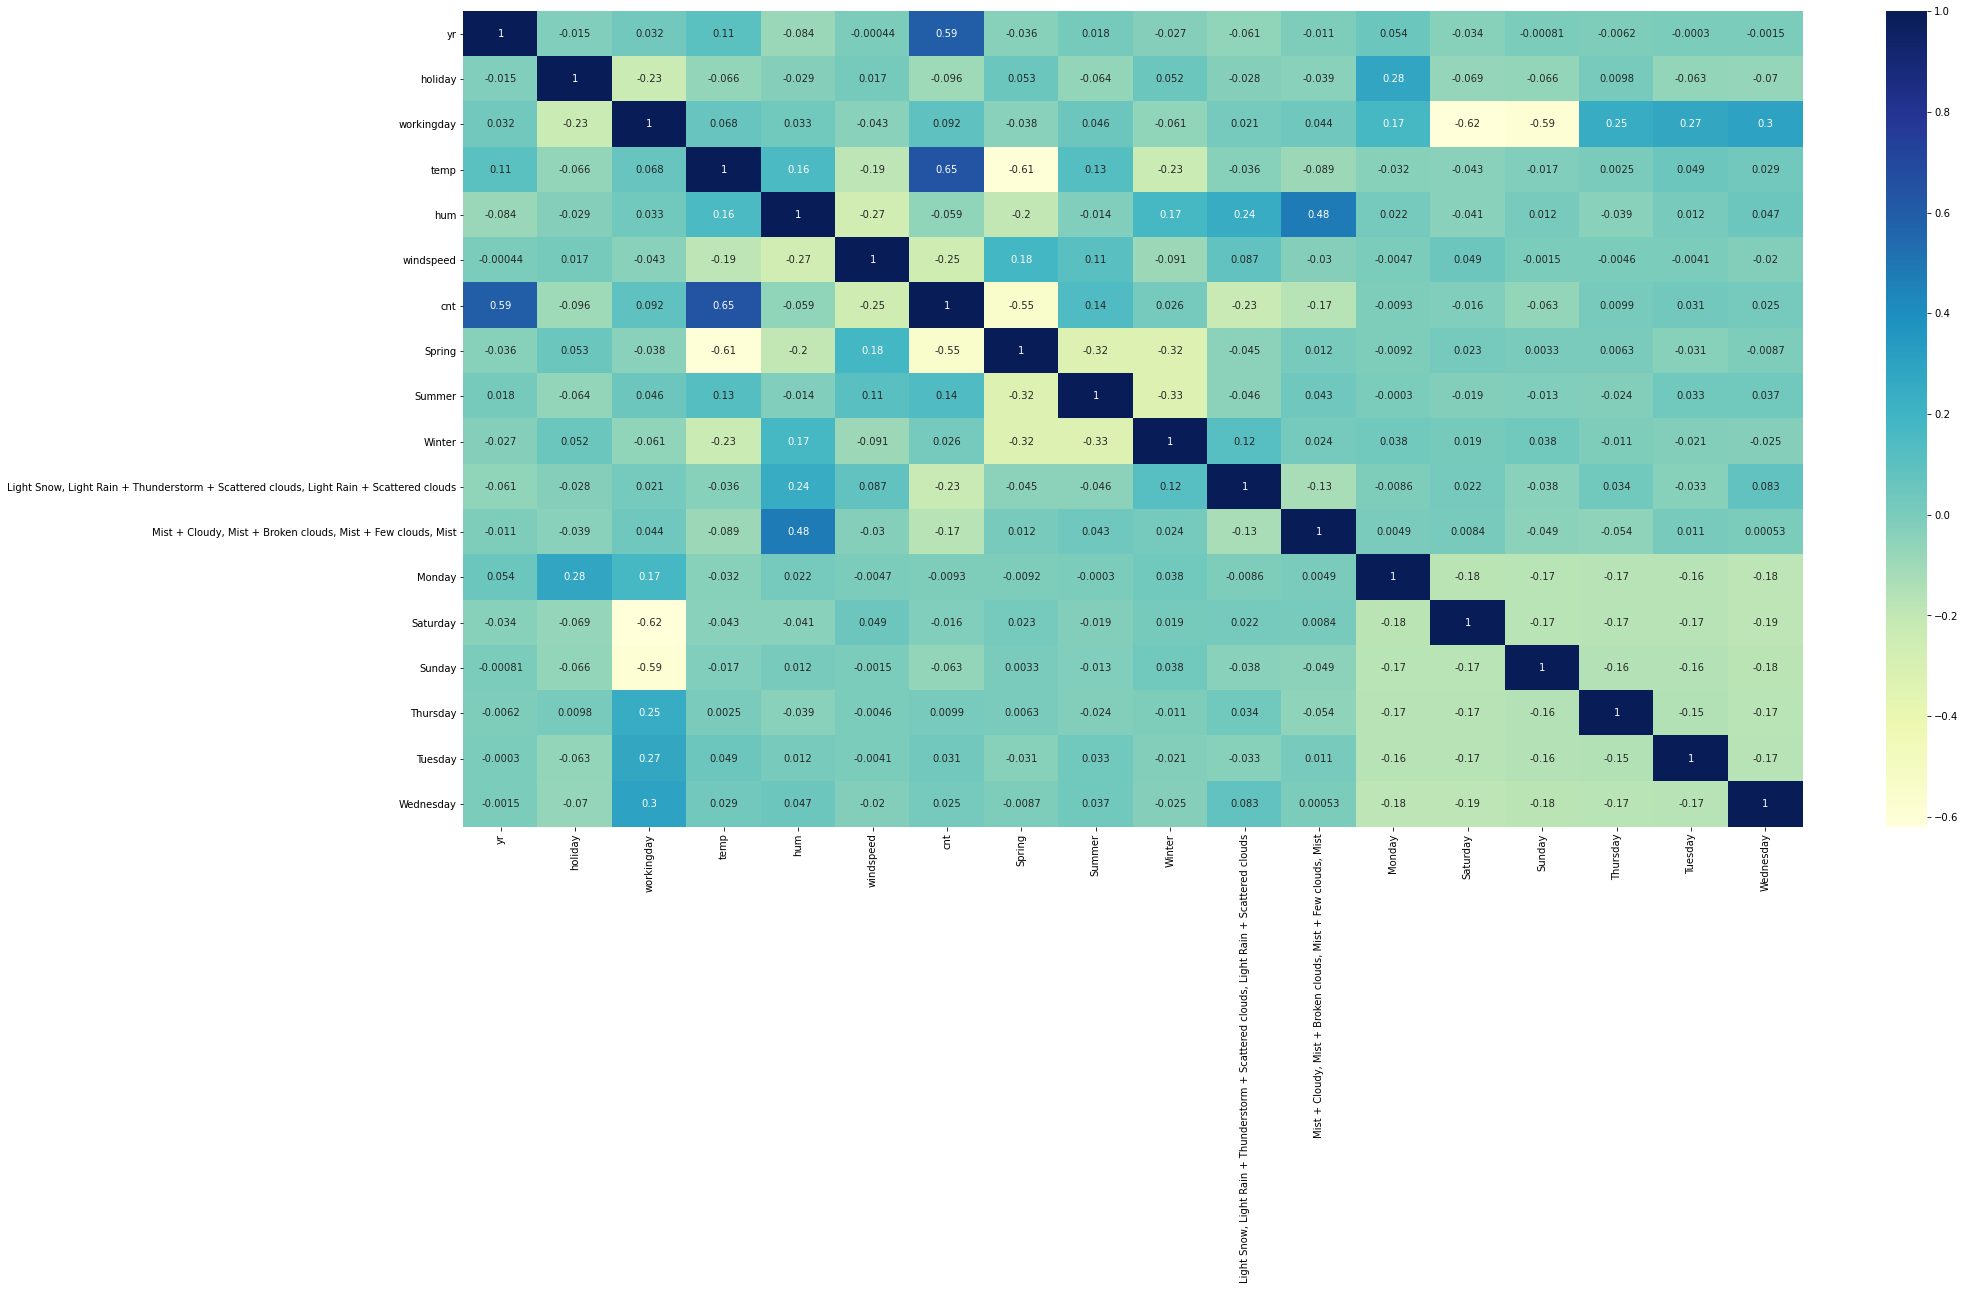

In [34]:
plt.figure(figsize = (30, 15))
sb.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [35]:
df_train.corr()['cnt'].sort_values(ascending=False)

cnt                                                                                        1.000000
temp                                                                                       0.645048
yr                                                                                         0.591433
Summer                                                                                     0.140259
workingday                                                                                 0.092019
Tuesday                                                                                    0.030528
Winter                                                                                     0.025945
Wednesday                                                                                  0.025468
Thursday                                                                                   0.009928
Monday                                                                                    -0.009333


### Observation
- Variables which have high correlation with `cnt` are
    - `temp` has correlation of `0.65`
    - `yr` has correlation of `0.59`
    

## Creating Train dataset to build the model

In [36]:
y_train = df_train.pop('cnt')
X_train = df_train

### Fitting the model using Ordinary Least Squares Method

In [37]:
X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train,X_train_sm).fit()

In [38]:
model.params

const                                                                                      0.212194
yr                                                                                         0.231733
holiday                                                                                    0.004108
workingday                                                                                 0.088392
temp                                                                                       0.493195
hum                                                                                       -0.126075
windspeed                                                                                 -0.180409
Spring                                                                                    -0.074712
Summer                                                                                     0.043783
Winter                                                                                     0.088878


In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     154.4
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          3.33e-180
Time:                        18:56:14   Log-Likelihood:                 496.28
No. Observations:                 510   AIC:                            -958.6
Df Residuals:                     493   BIC:                            -886.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                       0.2122      0.029      7.350      0.000       0.155       0.269
yr                                                                                          0.2317      0.008     27.609      0.000       0.215       0.248
holiday                                                                                     0.0041      0.024      0.171      0.864      -0.043       0.051
workingday                                                                                  0.0884      0.012      7.567      0.000       0.065       0.111
temp                                                                                        0.4932      0.034     14.413      0.000       0.426       0.560
hum                                                                                        -0.1261      0.039     -3.249      0.001      -0.202      -0.050
windspeed                                                                                  -0.1804      0.027     -6.794      0.000      -0.233      -0.128
Spring                                                                                     -0.0747      0.020     -3.646      0.000      -0.115      -0.034
Summer                                                                                      0.0438      0.014      3.185      0.002       0.017       0.071
Winter                                                                                      0.0889      0.017      5.284      0.000       0.056       0.122
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    -0.2500      0.027     -9.148      0.000      -0.304      -0.196
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               -0.0571      0.011     -5.238      0.000      -0.078      -0.036
Monday                                                                                     -0.0217      0.016     -1.351      0.177      -0.053       0.010
Saturday                                                                                    0.0880      0.013      6.738      0.000       0.062       0.114
Sunday                                                                                      0.0317      0.014      2.315      0.021       0.005       0.059
Thursday                                                                                   -0.0078      0.016     -0.478      0.633      -0.040       0.024
Tuesday                                                                                    -0.0185      0.016     -1.13

### Checking VIF

In [40]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,53.00
12,Saturday,11.94
13,Sunday,11.55
6,Spring,4.55
3,temp,3.51
8,Winter,3.10
1,holiday,3.10
7,Summer,2.07
11,Monday,1.95
16,Wednesday,1.92


### Dropping the variable and updating the model

- As you can see from the summary and the VIF dataframe, some variables are still insignificant. 
- Dropping __`holiday`__ columns as it has high p-value and low vif

In [41]:
X_train = X_train.drop(columns=['holiday'])

### Updating the model using Ordinary Least Squares Method with reduced features

In [42]:
X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train,X_train_sm).fit()

In [43]:
model.params

const                                                                                      0.216302
yr                                                                                         0.231733
workingday                                                                                 0.084284
temp                                                                                       0.493195
hum                                                                                       -0.126075
windspeed                                                                                 -0.180409
Spring                                                                                    -0.074712
Summer                                                                                     0.043783
Winter                                                                                     0.088878
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   -0.250000


In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     154.4
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          3.33e-180
Time:                        18:56:14   Log-Likelihood:                 496.28
No. Observations:                 510   AIC:                            -958.6
Df Residuals:                     493   BIC:                            -886.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                       0.2163      0.045      4.761      0.000       0.127       0.306
yr                                                                                          0.2317      0.008     27.609      0.000       0.215       0.248
workingday                                                                                  0.0843      0.027      3.070      0.002       0.030       0.138
temp                                                                                        0.4932      0.034     14.413      0.000       0.426       0.560
hum                                                                                        -0.1261      0.039     -3.249      0.001      -0.202      -0.050
windspeed                                                                                  -0.1804      0.027     -6.794      0.000      -0.233      -0.128
Spring                                                                                     -0.0747      0.020     -3.646      0.000      -0.115      -0.034
Summer                                                                                      0.0438      0.014      3.185      0.002       0.017       0.071
Winter                                                                                      0.0889      0.017      5.284      0.000       0.056       0.122
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    -0.2500      0.027     -9.148      0.000      -0.304      -0.196
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               -0.0571      0.011     -5.238      0.000      -0.078      -0.036
Monday                                                                                     -0.0217      0.016     -1.351      0.177      -0.053       0.010
Saturday                                                                                    0.0839      0.031      2.692      0.007       0.023       0.145
Sunday                                                                                      0.0276      0.031      0.880      0.379      -0.034       0.089
Thursday                                                                                   -0.0078      0.016     -0.478      0.633      -0.040       0.024
Tuesday                                                                                    -0.0185      0.016     -1.136      0.257      -0.050       0.013
Wednesday                                                                                  -0.0028      0.016     -0.17

### Checking VIF

In [45]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,32.39
1,workingday,19.34
2,temp,18.31
11,Saturday,5.57
12,Sunday,5.41
4,windspeed,4.96
5,Spring,4.55
7,Winter,3.42
6,Summer,2.48
9,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",2.35


### Removing wednesday as it has high p-value and low VIF

In [46]:
X_train = X_train.drop(columns=['Wednesday'])

In [47]:
X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train,X_train_sm).fit()

In [48]:
model.params

const                                                                                      0.215159
yr                                                                                         0.231711
workingday                                                                                 0.084165
temp                                                                                       0.493134
hum                                                                                       -0.126383
windspeed                                                                                 -0.180403
Spring                                                                                    -0.074792
Summer                                                                                     0.043673
Winter                                                                                     0.088812
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   -0.250320


In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     165.0
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          2.59e-181
Time:                        18:56:14   Log-Likelihood:                 496.26
No. Observations:                 510   AIC:                            -960.5
Df Residuals:                     494   BIC:                            -892.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                       0.2152      0.045      4.789      0.000       0.127       0.303
yr                                                                                          0.2317      0.008     27.637      0.000       0.215       0.248
workingday                                                                                  0.0842      0.027      3.070      0.002       0.030       0.138
temp                                                                                        0.4931      0.034     14.427      0.000       0.426       0.560
hum                                                                                        -0.1264      0.039     -3.264      0.001      -0.202      -0.050
windspeed                                                                                  -0.1804      0.027     -6.801      0.000      -0.233      -0.128
Spring                                                                                     -0.0748      0.020     -3.655      0.000      -0.115      -0.035
Summer                                                                                      0.0437      0.014      3.183      0.002       0.017       0.071
Winter                                                                                      0.0888      0.017      5.287      0.000       0.056       0.122
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    -0.2503      0.027     -9.189      0.000      -0.304      -0.197
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               -0.0569      0.011     -5.243      0.000      -0.078      -0.036
Monday                                                                                     -0.0202      0.014     -1.489      0.137      -0.047       0.006
Saturday                                                                                    0.0853      0.030      2.835      0.005       0.026       0.144
Sunday                                                                                      0.0290      0.030      0.958      0.339      -0.030       0.088
Thursday                                                                                   -0.0062      0.014     -0.455      0.650      -0.033       0.021
Tuesday                                                                                    -0.0169      0.014     -1.232      0.218      -0.044       0.010
==============================================================================
Omnibus:                       71.692   

### Checking VIF

In [50]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,31.94
1,workingday,18.97
2,temp,18.17
11,Saturday,5.31
12,Sunday,5.15
4,windspeed,4.95
5,Spring,4.49
7,Winter,3.40
6,Summer,2.46
9,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",2.33


### Dropping the variable and updating the model

- As you can see from the summary and the VIF dataframe, some variables are still insignificant. 
- Dropping __`Thursday`__ columns as it has high p-value and low vif

In [51]:
X_train = X_train.drop(columns=['Thursday'])


- ### Let's extract the features(independent variables) using RFE

In [52]:
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,10) #running RFE
rfe = rfe.fit(X_train,y_train)

In [53]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 3),
 ('Winter', True, 1),
 ('Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
  True,
  1),
 ('Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', True, 1),
 ('Monday', False, 4),
 ('Saturday', True, 1),
 ('Sunday', False, 2),
 ('Tuesday', False, 5)]

### From the above rankings let's drop the features which were not selected

In [54]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Winter',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Saturday'],
      dtype='object')

### Updating the model using Ordinary Least Squares Method with features identified from RFE

In [55]:
X_train_rfe = X_train[col]

In [56]:
X_train_sm = sm.add_constant(X_train_rfe)

model = sm.OLS(y_train,X_train_sm).fit()

In [57]:
model.params

const                                                                                      0.285790
yr                                                                                         0.232582
workingday                                                                                 0.053631
temp                                                                                       0.439469
hum                                                                                       -0.116265
windspeed                                                                                 -0.168283
Spring                                                                                    -0.118316
Winter                                                                                     0.052837
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   -0.253899
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                              -0.057323


In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     240.7
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          9.63e-184
Time:                        18:56:14   Log-Likelihood:                 488.19
No. Observations:                 510   AIC:                            -954.4
Df Residuals:                     499   BIC:                            -907.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                       0.2858      0.034      8.457      0.000       0.219       0.352
yr                                                                                          0.2326      0.008     27.536      0.000       0.216       0.249
workingday                                                                                  0.0536      0.011      4.694      0.000       0.031       0.076
temp                                                                                        0.4395      0.030     14.810      0.000       0.381       0.498
hum                                                                                        -0.1163      0.039     -2.988      0.003      -0.193      -0.040
windspeed                                                                                  -0.1683      0.026     -6.360      0.000      -0.220      -0.116
Spring                                                                                     -0.1183      0.015     -7.695      0.000      -0.149      -0.088
Winter                                                                                      0.0528      0.013      4.118      0.000       0.028       0.078
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    -0.2539      0.027     -9.260      0.000      -0.308      -0.200
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               -0.0573      0.011     -5.236      0.000      -0.079      -0.036
Saturday                                                                                    0.0627      0.015      4.259      0.000       0.034       0.092
==============================================================================
Omnibus:                       73.939   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.454
Skew:                          -0.717   Prob(JB):                     8.06e-44
Kurtosis:                       5.699   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking VIF

In [59]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,22.47
2,temp,13.50
1,workingday,4.62
4,windspeed,4.05
5,Spring,2.56
8,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",2.23
6,Winter,2.08
0,yr,2.06
9,Saturday,1.82
7,"Light Snow, Light Rain + Thunderstorm + Scatte...",1.20


### Dropping the variable and updating the model

- `hum` has low p-value and high VIF value(23)
- Dropping this features

In [60]:
X_train_rfe = X_train_rfe.drop(columns=['hum'])

### Updating the model using Ordinary Least Squares Method with reduced features

In [61]:
X_train_sm = sm.add_constant(X_train_rfe)

model = sm.OLS(y_train,X_train_sm).fit()

In [62]:
model.params

const                                                                                      0.220171
yr                                                                                         0.235305
workingday                                                                                 0.055534
temp                                                                                       0.419899
windspeed                                                                                 -0.145963
Spring                                                                                    -0.120689
Winter                                                                                     0.045756
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds   -0.286066
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                              -0.076335
Saturday                                                                                   0.066015


In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     262.3
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          4.76e-183
Time:                        18:56:14   Log-Likelihood:                 483.67
No. Observations:                 510   AIC:                            -947.3
Df Residuals:                     500   BIC:                            -905.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                       0.2202      0.026      8.504      0.000       0.169       0.271
yr                                                                                          0.2353      0.008     27.802      0.000       0.219       0.252
workingday                                                                                  0.0555      0.011      4.830      0.000       0.033       0.078
temp                                                                                        0.4199      0.029     14.395      0.000       0.363       0.477
windspeed                                                                                  -0.1460      0.026     -5.705      0.000      -0.196      -0.096
Spring                                                                                     -0.1207      0.015     -7.798      0.000      -0.151      -0.090
Winter                                                                                      0.0458      0.013      3.600      0.000       0.021       0.071
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    -0.2861      0.025    -11.256      0.000      -0.336      -0.236
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               -0.0763      0.009     -8.500      0.000      -0.094      -0.059
Saturday                                                                                    0.0660      0.015      4.460      0.000       0.037       0.095
==============================================================================
Omnibus:                       72.583   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.948
Skew:                          -0.712   Prob(JB):                     5.67e-42
Kurtosis:                       5.629   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking VIF

In [64]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,5.26
1,workingday,4.44
3,windspeed,4.04
0,yr,2.06
4,Spring,1.80
8,Saturday,1.79
7,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",1.53
5,Winter,1.42
6,"Light Snow, Light Rain + Thunderstorm + Scatte...",1.08


### Observations

- As you we know temp has high correlation with demand we will not drop
- VIF for all features are under considerable range

### Adjusted R-Squared for the Model is 0.822 and it almost equal to calculated R-squared
- As almost most VIF and p-values values are under considerable range these would be the final features

## Residual Analysis of the train data

In [65]:
y_train_pred = model.predict(X_train_sm)

Text(0.5, 0, 'Errors')

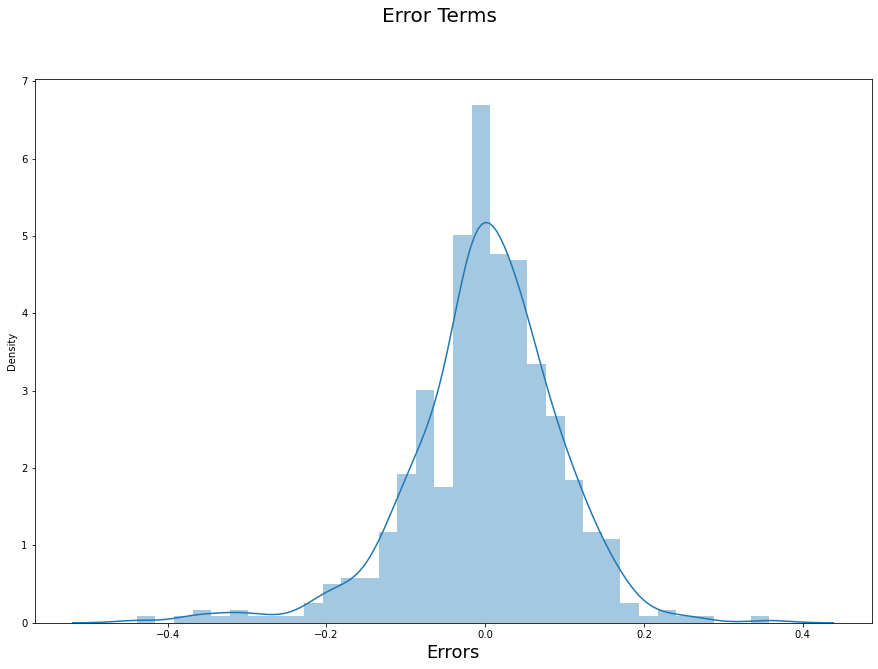

In [66]:
fig = plt.figure(figsize=(15,10))
sb.distplot((y_train - y_train_pred))
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Observation : 
- As we can see most values are centered around `0` following a normal distribution 
- It satisfies our assumptions for linear regression

### R2 Score on train data

In [67]:
r2_score(y_train,y_train_pred)

0.8252127139366122

### Model Accuracy on train data is `82.5%`

## Making Predictions on the test data

In [68]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [69]:
list(X_train_rfe.columns)

['yr',
 'workingday',
 'temp',
 'windspeed',
 'Spring',
 'Winter',
 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
 'Saturday']

In [70]:
y_test = df_test['cnt']
X_test = df_test[list(X_train_rfe.columns)]

In [71]:
X_test_sm = sm.add_constant(X_test)
y_test_pred = model.predict(X_test_sm)

### Residual Analysis on Test data

Text(0.5, 0, 'Errors')

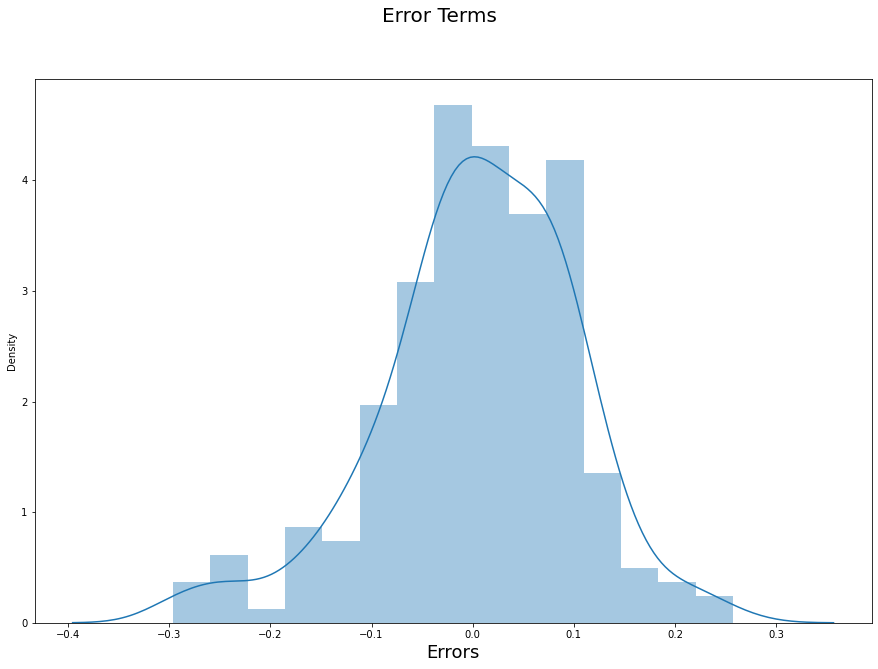

In [72]:
fig = plt.figure(figsize=(15,10))
sb.distplot((y_test - y_test_pred))
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### It follows the normal distribution(most of the values are centered around zero) hence proving the assumption of linear regression

In [73]:
r2_score(y_test,y_test_pred)

0.8025576411123327

### Model Accuracy on test data is `80.2%`
